In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from acea.model_evaluation import *

In [15]:
FORECAST_PERIOD = 30
TEST_PERIOD = 30
TRAIN_PERIOD = 730

In [16]:
def load_data(files):
    
    # initiate dict to store data
    dfs = {}

    for f in files:

        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
    
        # load the data
        df = pd.read_csv(f)

        # get start and end data of the data
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])

        # store data in dictionary by water body name
        dfs[database] = df
    
    return dfs

def load_data(files):
    
    # initiate dict to store data
    dfs = {}

    for f in files:

        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
    
        # load the data
        df = pd.read_csv(f)

        # get start and end data of the data
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])

        # store data in dictionary by water body name
        dfs[database] = df
    
    return dfs

    

In [17]:
datadir = '../data'
basedir = os.path.join(datadir, 'featseng', 'D%d'%FORECAST_PERIOD, '*csv')


files = glob.glob(basedir)
dfs = load_data(files)


In [18]:
datadir = '../data'
cleandir = os.path.join(datadir, 'clean')
featsdir = os.path.join(datadir, 'featseng', 'D%d'%FORECAST_PERIOD)


In [19]:
files = glob.glob(os.path.join(featsdir, '*.csv'))
filename_cols = glob.glob(os.path.join(cleandir, '*.xlsx'))[0]

In [20]:
dfcols = pd.read_excel(filename_cols, engine='openpyxl')
dfs = load_data(files)
names = list(dfs.keys())
names

['Aquifer_Auser', 'Aquifer_Petrignano', 'Lake_Bilancino', 'River_Arno']

# Baseline: last known value



Aquifer_Auser
   Depth_to_Groundwater_SAL
{'r2': 0.28649738237417965, 'rmse': 0.14447205940482882, 'mae': 0.2550735345951852, 'mape': 0.0496755851528734}
   Depth_to_Groundwater_COS
{'r2': 0.6430665427271163, 'rmse': 0.62956190010438, 'mae': 0.6212477203449467, 'mape': 0.10346840048495301}
   Depth_to_Groundwater_LT2
{'r2': 0.7235724634678387, 'rmse': 0.024552938909506678, 'mae': 0.12529237601776463, 'mape': 0.009947341646978587}
Aquifer_Petrignano
   Depth_to_Groundwater_P24
{'r2': 0.7989232360067537, 'rmse': 0.33936081832593534, 'mae': 0.4478097653772988, 'mape': 0.01752606531771464}
   Depth_to_Groundwater_P25
{'r2': 0.8202939975772988, 'rmse': 0.2677540203709575, 'mae': 0.38915662650602406, 'mape': 0.015476815473607117}
Lake_Bilancino
   Lake_Level
{'r2': 0.6726805057924277, 'rmse': 1.5603333221813316, 'mae': 0.8923285379725664, 'mape': 0.0035796046832379655}
   Flow_Rate
{'r2': -0.6647013665800583, 'rmse': 27.776616627634663, 'mae': 2.3222582803613245, 'mape': 1.2538151226272434}


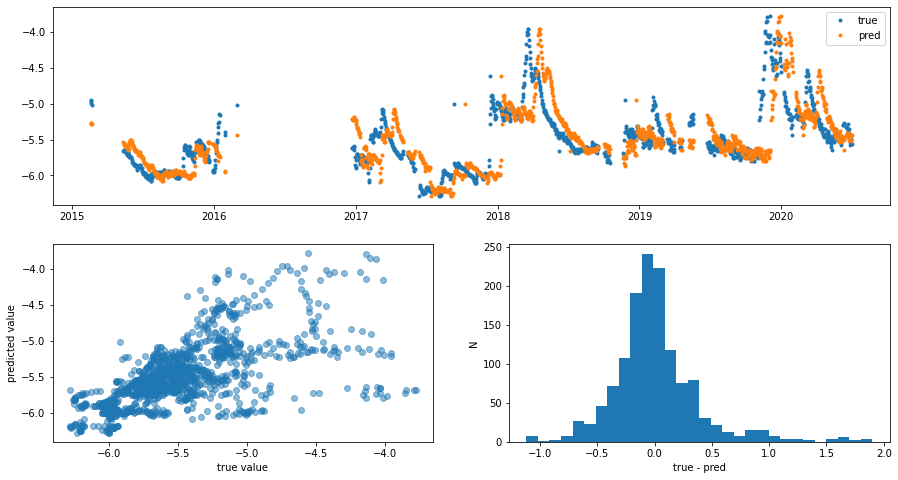

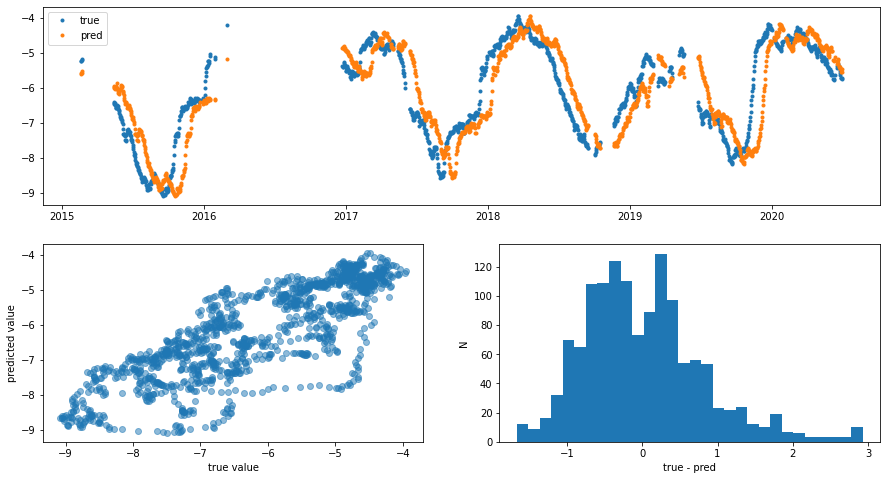

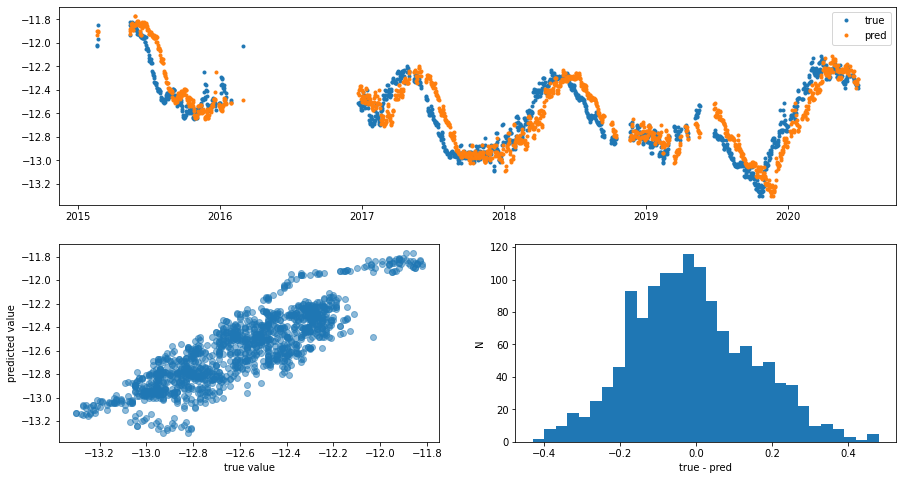

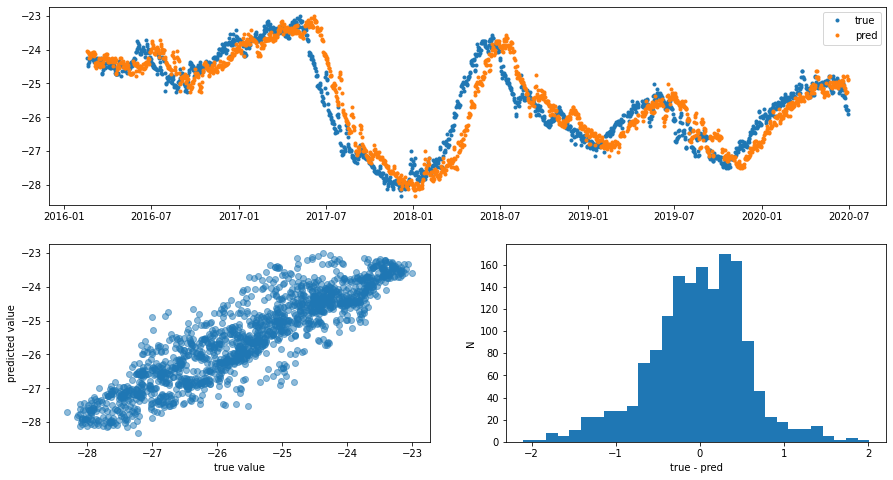

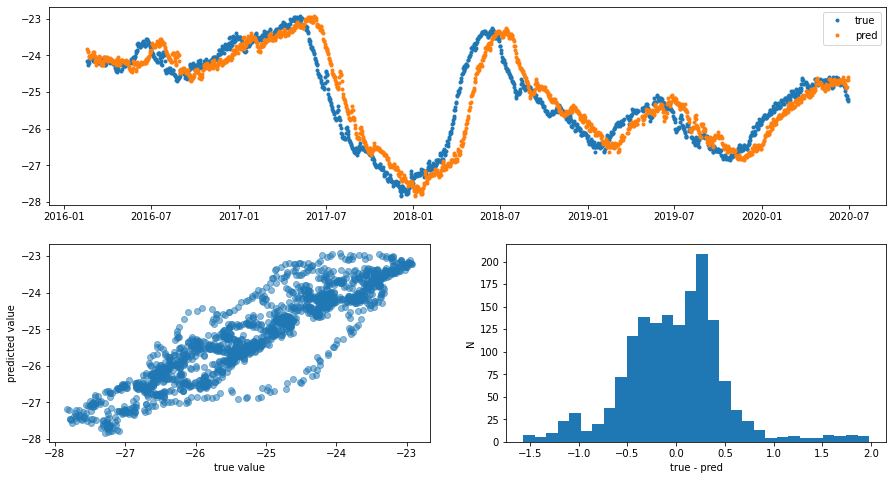

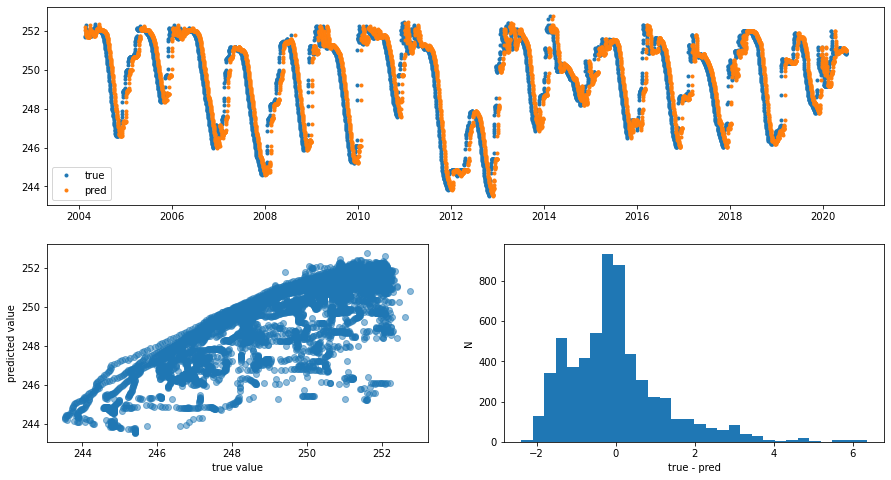

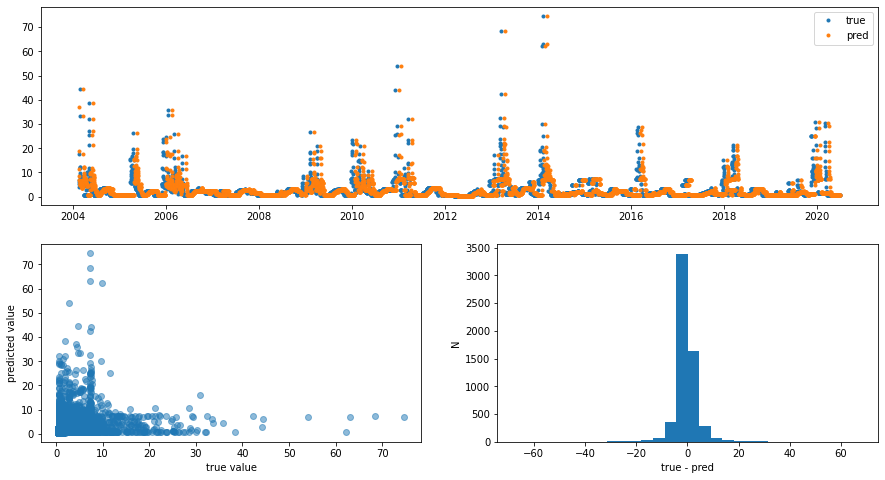

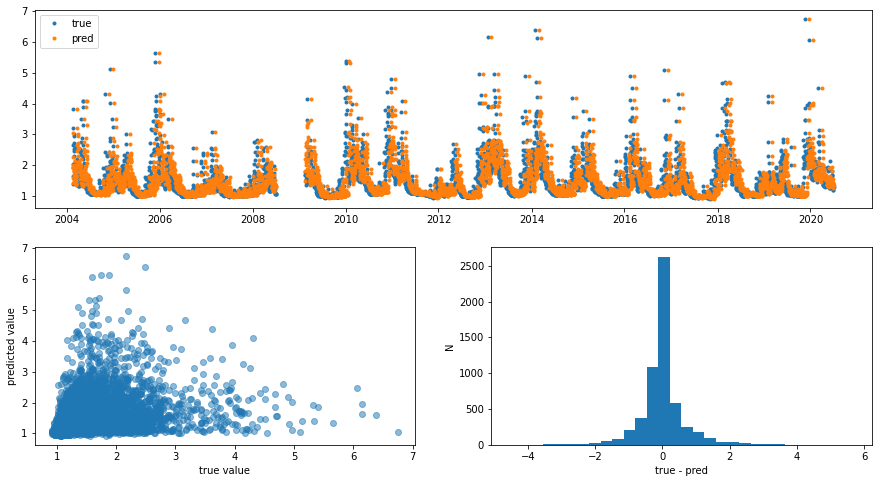

In [21]:
for name in names:
    print(name)
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    try:
        df = dfs[name]
        for target in targets:
            feature = 'auto_' + target
            x = df[['Date',target, feature]].dropna()['Date']
            y_true = df[['Date',target, feature]].dropna()[target]
            y_pred = df[['Date',target, feature]].dropna()[feature]
            print('  ', target)
            print(evaluation_metrics(y_true, y_pred))
            model_evaluation_plots(x, y_true, y_pred)
    except:
        print('auto var unavailable for', name)


# From package implementation

- R2 scores measured over a small period are way worse.. This is probably because the scale of variation within the small period is smaller which aritificially emplifies the mismatch between true value and predicted value!

In [22]:
from acea.models import BaseModel


In [23]:
def get_batch(df):
    n = int(np.floor((len(df)-TRAIN_PERIOD)/TEST_PERIOD))
    for i in range(n):
        yield i*TEST_PERIOD, TRAIN_PERIOD + i*TEST_PERIOD, TRAIN_PERIOD + (i+1)*TEST_PERIOD 
        
def get_custom_batch(df, train_period, test_period):
    n = int(np.floor((len(df)-train_period)/test_period))
    for i in range(n):
        yield i*test_period, train_period + i*test_period, train_period + (i+1)*test_period 
    
def get_scores_for_basemodel(df, target, train_period=None, test_period=None):
    
    feature = 'auto_' + target
    x = ['Date']
    
    y = df[[target]].values
    X = df[[feature]].values

    base_model = BaseModel()
    base_model_scores = []

    if train_period and test_period:
        batches = get_custom_batch(df, train_period, test_period)
    else:
        batches = get_batch(df)

    for i,j,k in batches:

        # get train-test sets
        X_train, X_test = X[i:j], X[j:k]
        y_train, y_test = y[i:j], y[j:k]

        # fit model
        base_model.fit(X_train, y_train)

        # predict
        y_pred = base_model.predict(X_test)

        # model evaluation
        base_model_scores.append(evaluation_metrics(y_test, y_pred))

    # get summary statistics of scores
    summary = pd.DataFrame(base_model_scores).agg(['mean', 'std']).T
    
    return summary,  base_model_scores

In [24]:
def create_latex_score_summary(names, summary):

    lines = []
    for name in names:
        dfsum = summary[name].copy()
        dfsum = dfsum.T
        dfsum['r2'] = dfsum['r2'].apply(lambda x: np.sign(x) * np.inf if abs(x) > 1E6 else x)
        dfsum = dfsum.T
        dfsum[name] = dfsum.apply(lambda x: '$ %.2f \\pm %.2f $'%(x['mean'], x['std']), axis=1)
        lines.append(dfsum[[name]].T)
        
    dftable = pd.concat(lines)
    latextable = dftable.to_latex().replace('\\textbackslash pm','\pm').replace('\$','$')
    
    return latextable

In [25]:
summary = {}
scores = {}
names_for_table = []
for name in names:
    
    
    df = dfs[name]
    targets = dfcols[(dfcols['name']==name) & (dfcols['coltype']=='target')]['colname'].unique()
    print(targets)

    print('#'*20, 'Processing', name, target, '#'*20)
    
    for target in targets:
        names_for_table.append('%s_%s'%(name, target))

        basemodel_scores = get_scores_for_basemodel(df, target, train_period=365*2, test_period=30)
        summary['%s_%s'%(name, target)], scores['%s_%s'%(name, target)] = basemodel_scores

['Depth_to_Groundwater_SAL' 'Depth_to_Groundwater_COS'
 'Depth_to_Groundwater_LT2']
#################### Processing Aquifer_Auser Hydrometry_Nave_di_Rosano ####################
['Depth_to_Groundwater_P24' 'Depth_to_Groundwater_P25']
#################### Processing Aquifer_Petrignano Depth_to_Groundwater_LT2 ####################
['Lake_Level' 'Flow_Rate']
#################### Processing Lake_Bilancino Depth_to_Groundwater_P25 ####################
['Hydrometry_Nave_di_Rosano']
#################### Processing River_Arno Flow_Rate ####################


In [26]:
print(create_latex_score_summary(names_for_table, summary))

\begin{tabular}{lllll}
\toprule
{} &                      r2 &                 rmse &                mae &               mape \\
\midrule
Aquifer\_Auser\_Depth\_to\_Groundwater\_SAL      &      $ -8.14 \pm 9.50 $ &    $ 0.18 \pm 0.32 $ &  $ 0.27 \pm 0.23 $ &  $ 0.05 \pm 0.05 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_COS      &    $ -17.28 \pm 36.43 $ &    $ 0.70 \pm 1.02 $ &  $ 0.64 \pm 0.42 $ &  $ 0.11 \pm 0.08 $ \\
Aquifer\_Auser\_Depth\_to\_Groundwater\_LT2      &      $ -5.35 \pm 5.87 $ &    $ 0.02 \pm 0.02 $ &  $ 0.13 \pm 0.06 $ &  $ 0.01 \pm 0.00 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P24 &      $ -6.29 \pm 5.78 $ &    $ 0.37 \pm 0.44 $ &  $ 0.48 \pm 0.29 $ &  $ 0.02 \pm 0.01 $ \\
Aquifer\_Petrignano\_Depth\_to\_Groundwater\_P25 &     $ -9.99 \pm 15.11 $ &    $ 0.31 \pm 0.53 $ &  $ 0.42 \pm 0.33 $ &  $ 0.02 \pm 0.01 $ \\
Lake\_Bilancino\_Lake\_Level                   &  $ -101.37 \pm 475.53 $ &    $ 1.64 \pm 3.21 $ &  $ 0.91 \pm 0.79 $ &  $ 0.00 \pm 0.00 $ \\
Lake\_